***
DB connection
***

In [1]:
from __future__ import annotations

import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

DB_HOST = os.getenv("JANUS_DB_HOST", "localhost")
DB_PORT = os.getenv("JANUS_DB_PORT", "5433")
DB_NAME = os.getenv("JANUS_DB_NAME", "airflow")
DB_USER = os.getenv("JANUS_DB_USER", "janus")
DB_PASS = os.getenv("JANUS_DB_PASS", "janus_password")

DB_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DB_URL)

with engine.begin() as conn:
    ok = conn.execute(text("select 1")).scalar()
ok


1

***
Pull relevant gold marts
***

In [2]:
df_plan = pd.read_sql(
    text("""
        select *
        from dbt.gold_churn_by_plan_daily
        order by date_day, plan_id
    """),
    engine
)

df_overall = pd.read_sql(
    text("""
        select
          date_day,
          count(*) as rows,
          sum(churn_7d)::int as churners,
          (avg(churn_7d)::float) as churn_rate
        from dbt.gold_user_features_daily
        group by 1
        order by 1
    """),
    engine
)

df_plan.head(), df_overall.head()


(     date_day plan_id  users  churners  churn_rate_pct
 0  2026-01-01   basic      8         1            12.5
 1  2026-01-01    free    470         0             0.0
 2  2026-01-01     pro      5         0             0.0
 3  2026-01-01    team      8         0             0.0
 4  2026-01-02   basic     16         0             0.0,
      date_day  rows  churners  churn_rate
 0  2026-01-01   491         1    0.002037
 1  2026-01-02   491         0    0.000000
 2  2026-01-03   491         1    0.002037
 3  2026-01-04   491         2    0.004073
 4  2026-01-05   491         1    0.002037)

***
Overall churn trends over time
***

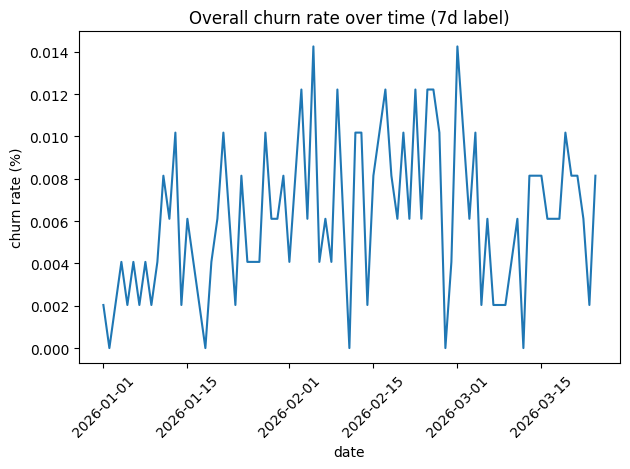

In [9]:
x = pd.to_datetime(df_overall["date_day"])

plt.figure()
plt.plot(x, df_overall["churn_rate"])
plt.title("Overall churn rate over time (7d label)")
plt.xlabel("date")
plt.ylabel("churn rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


***
Churn by plan
***

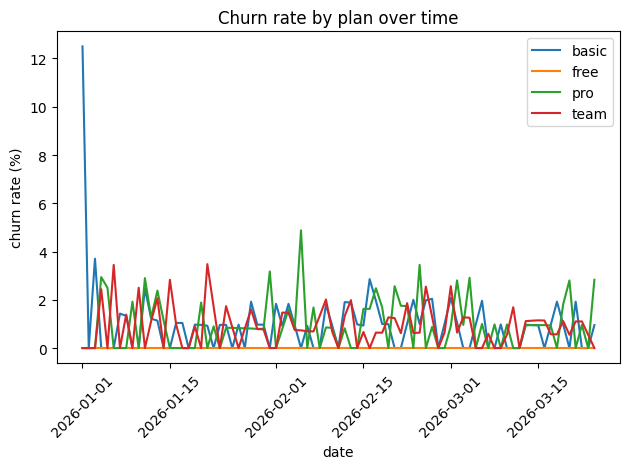

In [10]:
dfp = df_plan.copy()
dfp["date_day"] = pd.to_datetime(dfp["date_day"])

pivot_rate = dfp.pivot(index="date_day", columns="plan_id", values="churn_rate_pct").sort_index()

plt.figure()
for col in pivot_rate.columns:
    plt.plot(pivot_rate.index, pivot_rate[col], label=str(col))
plt.title("Churn rate by plan over time")
plt.xlabel("date")
plt.ylabel("churn rate (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



***
Users by plan
***

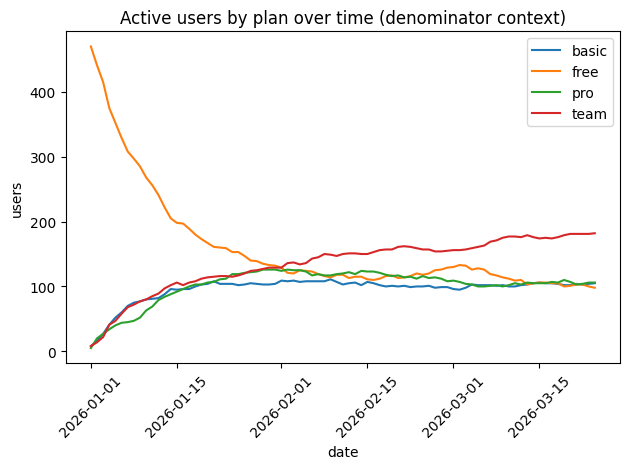

In [11]:
pivot_users = dfp.pivot(index="date_day", columns="plan_id", values="users").sort_index()

plt.figure()
for col in pivot_users.columns:
    plt.plot(pivot_users.index, pivot_users[col], label=str(col))
plt.title("Active users by plan over time (denominator context)")
plt.xlabel("date")
plt.ylabel("users")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


***
Schema drift curve
***

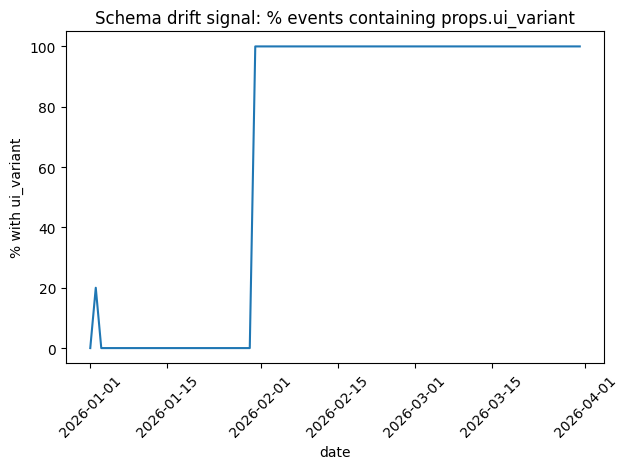

In [12]:
df_ui = pd.read_sql(
    text("""
        select
          event_ts::date as date_day,
          avg(case when (props ? 'ui_variant') then 1 else 0 end)::float * 100.0 as pct_ui_variant
        from silver.silver_events
        group by 1
        order by 1
    """),
    engine
)
df_ui["date_day"] = pd.to_datetime(df_ui["date_day"])

plt.figure()
plt.plot(df_ui["date_day"], df_ui["pct_ui_variant"])
plt.title("Schema drift signal: % events containing props.ui_variant")
plt.xlabel("date")
plt.ylabel("% with ui_variant")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


***
Late events over time
***

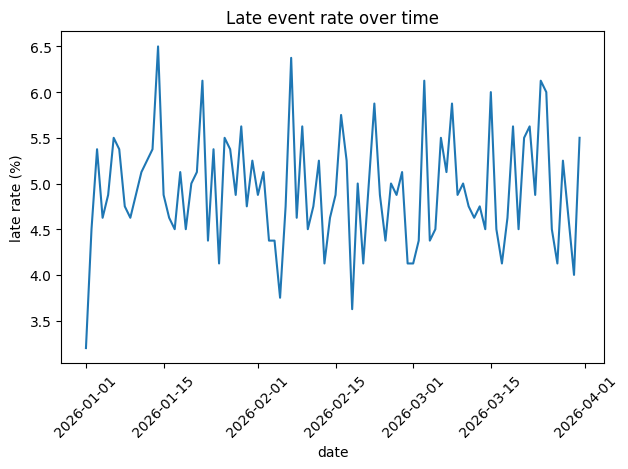

In [18]:
df_late = pd.read_sql(
    text("""
        select
          event_ts::date as date_day,
          avg(is_late::int)::float * 100.0 as late_rate_pct,
          sum(is_late::int)::int as late_events,
          count(*)::int as events
        from silver.silver_events
        group by 1
        order by 1
    """),
    engine
)

df_late["date_day"] = pd.to_datetime(df_late["date_day"])

plt.figure()
plt.plot(df_late["date_day"], df_late["late_rate_pct"])
plt.title("Late event rate over time")
plt.xlabel("date")
plt.ylabel("late rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


***
Export charts
***

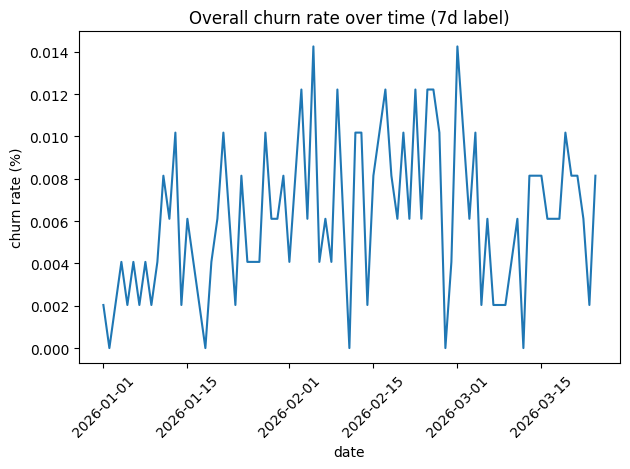

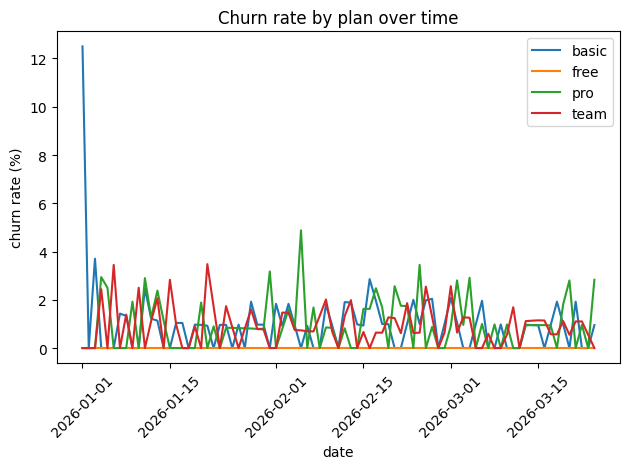

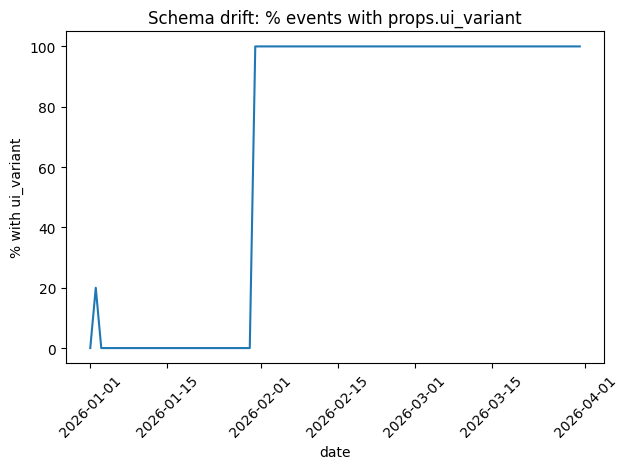

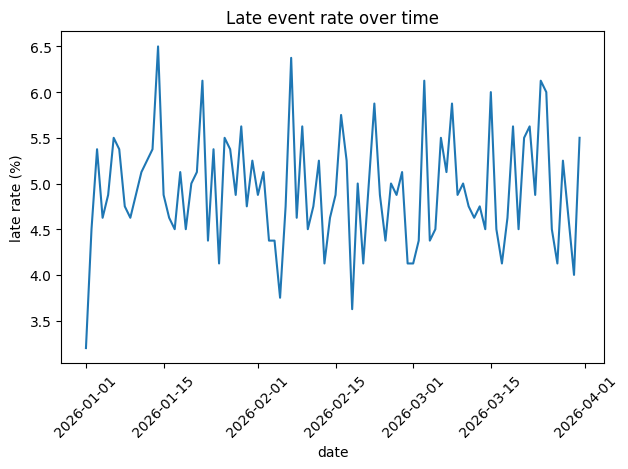

In [21]:
Path("reports/figures").mkdir(parents=True, exist_ok=True)

def save_fig(path: str):
    plt.tight_layout()
    plt.savefig(path, dpi=200)

# churn overall
plt.figure()
plt.plot(x, df_overall["churn_rate"])
plt.title("Overall churn rate over time (7d label)")
plt.xlabel("date")
plt.ylabel("churn rate (%)")
plt.xticks(rotation=45)
save_fig("reports/figures/churn_overall.png")
plt.show()

# churn by plan
plt.figure()
for col in pivot_rate.columns:
    plt.plot(pivot_rate.index, pivot_rate[col], label=str(col))
plt.title("Churn rate by plan over time")
plt.xlabel("date")
plt.ylabel("churn rate (%)")
plt.xticks(rotation=45)
plt.legend()
save_fig("reports/figures/churn_by_plan.png")
plt.show()

# schema drift
plt.figure()
plt.plot(df_ui["date_day"], df_ui["pct_ui_variant"])
plt.title("Schema drift: % events with props.ui_variant")
plt.xlabel("date")
plt.ylabel("% with ui_variant")
plt.xticks(rotation=45)
save_fig("reports/figures/schema_drift_ui_variant.png")
plt.show()

# late event rate
plt.figure()
plt.plot(df_late["date_day"], df_late["late_rate_pct"])
plt.title("Late event rate over time")
plt.xlabel("date")
plt.ylabel("late rate (%)")
plt.xticks(rotation=45)
save_fig("reports/figures/late_events.png")
plt.show()
